In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [334]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from dataloader import get_single_hits, get_event_hits
from sklearn.model_selection import train_test_split

from scipy import constants

import gc


#import eli5
#from eli5.sklearn import PermutationImportance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [543]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
tf.test.is_gpu_available()

True

In [47]:
labels = ['x', 'y', 'z', 'time', 'azimuth','zenith', 'energy']

In [82]:
hits, charges, params = get_single_hits('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5', labels=labels)

 79%|███████▊  | 78624/100000 [00:03<00:01, 20027.23it/s]


In [238]:
hits_list = []
charges_list = []
params_list = []

for i in range(10):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        hits, charges, params = get_single_hits(
            fname,
            labels = labels,
            )
        hits_list.append(hits)
        charges_list.append(charges)
        params_list.append(params)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

hits = np.concatenate(hits_list)
charges = np.concatenate(charges_list)
params = np.concatenate(params_list)



  0%|          | 0/406784 [00:00<?, ?it/s]

Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 405293/405293 [00:25<00:00, 15999.20it/s]


In [239]:
hits_train, hits_test, charges_train, charges_test, params_train, params_test = train_test_split(hits, charges, params, test_size=0.1, random_state=42)

In [592]:
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')
time_idx = labels.index('time')
x_idx = labels.index('x')
y_idx = labels.index('y')
z_idx = labels.index('z')
energy_idx = labels.index('energy')

c = constants.c * 1e-9 # c in m / ns

class trafo(tf.keras.layers.Layer):

    def call(self, hit, params):
        
        dir_x = tf.math.sin(params[:, zenith_idx]) * tf.math.cos(params[:, azimuth_idx])
        dir_y = tf.math.sin(params[:, zenith_idx]) * tf.math.sin(params[:, azimuth_idx])
        dir_z = tf.math.cos(params[:, zenith_idx])
        
        d_time = hit[:,3] - params[:, time_idx]
        d_x = hit[:,0] - params[:, x_idx]
        d_y = hit[:,1] - params[:, y_idx]
        d_z = hit[:,2] - params[:, z_idx]
        
        dist = tf.math.sqrt(tf.math.square(d_x) + tf.math.square(d_y) + tf.math.square(d_z))
        
        # difference c*t - r
        delta = d_time * c - dist

        energy = params[:, energy_idx]
        
        out = tf.concat([hit[:, 0:3], delta[:, tf.newaxis], dist[:, tf.newaxis], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis], energy[:, tf.newaxis]], axis=1)
                
        return out

In [593]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        
    def on_test_batch_end(self, batch, logs={}):
        self.test_losses.append(logs.get('loss'))
   

In [594]:
activation='relu'


hits_input = tf.keras.Input(shape=(4,))
params_input = tf.keras.Input(shape=(len(labels),))
t = trafo()

h = t(hits_input, params_input)
h = tf.keras.layers.Dense(32, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dense(256, activation="relu")(h)
h = tf.keras.layers.Dense(128, activation="relu")(h)
h = tf.keras.layers.Dense(64, activation="relu")(h)
h = tf.keras.layers.Dense(32, activation="relu")(h)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)


model = tf.keras.Model(inputs=[hits_input, params_input], outputs=outputs)


model.summary()

my_history = LossHistory()


loss_history = []
val_loss_history = []

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
trafo_13 (trafo)                (None, 9)            0           input_25[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 32)           320         trafo_13[0][0]                   
____________________________________________________________________________________________

In [595]:
optimizer = tf.keras.optimizers.Adam(0.0005)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [599]:
np.random.permutation(params_test)

array([[ 3.8872345e+01, -1.2461709e+02, -4.8268250e+02, ...,
         5.0784721e+00,  8.1562907e-01,  6.3562328e+01],
       [ 2.2094761e+01, -1.2967590e+02, -3.7971097e+02, ...,
         5.6476521e+00,  9.6559125e-01,  1.7597979e+01],
       [ 3.6165371e+01,  5.4926357e+01, -3.4857379e+02, ...,
         7.8180701e-01,  9.2519593e-01,  1.0137006e+02],
       ...,
       [-4.0253662e+01, -1.9971094e+02, -3.3439798e+02, ...,
         3.6695933e+00,  1.9283376e+00,  7.8455444e+01],
       [ 2.2236870e+01, -7.8547668e+01, -2.0409210e+02, ...,
         3.4141743e+00,  4.9742064e-01,  2.4824667e+01],
       [-1.8858121e+02,  5.0705056e+00, -5.4792474e+02, ...,
         3.9052780e+00,  2.3123314e+00,  2.6698971e+01]], dtype=float32)

In [600]:
def shuffle(hits, params, each_row=True):
    shuffled_hits = np.vstack([hits, hits])
    if each_row:
        shuf = np.empty_like(params)
        for col in range(params.shape[1]):
            indices = np.random.permutation(np.arange(params.shape[0]))
            shuf[:, col] = params[indices, col]
    else:
        shuf = np.random.permutation(params)
    shuffled_params = np.vstack([params, shuf])
    target = np.concatenate([np.ones(hits.shape[0]), np.zeros(hits.shape[0])])
    return shuffled_hits, shuffled_params, target

In [ ]:
for i in range(10):
    
    shuffled_hits_train, shuffled_params_train, outputs_train = shuffle(hits_train, params_train)
    shuffled_hits_test, shuffled_params_test, outputs_test = shuffle(hits_test, params_test)
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    model.fit([shuffled_hits_train, shuffled_params_train], outputs_train, batch_size=2048, epochs=1, validation_data=([shuffled_hits_test, shuffled_params_test], outputs_test), callbacks=[my_history,])

    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

Epoch 3
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 13s 2us/sample - loss: 0.3483 - val_loss: 0.3474
Epoch 4
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 13s 2us/sample - loss: 0.3465 - val_loss: 0.3466
Epoch 5
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 13s 2us/sample - loss: 0.3447 - val_loss: 0.3433
Epoch 6
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 12s 2us/sample - loss: 0.3435 - val_loss: 0.3435
Epoch 7
Train on 6732774 samples, validate on 748086 samples
6732774/6732774 [==============================] - 13s 2us/sample - loss: 0.3420 - val_loss: 0.3414


In [331]:
hit_idx = 404

true_params = params_test[hit_idx]
true_hit = hits_test[hit_idx]

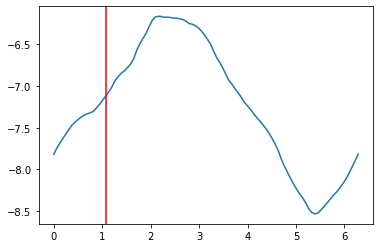

In [333]:
plot_dim = 'azimuth'
plot_idx = labels.index(plot_dim)

true_p = true_params[plot_idx]

if plot_dim == 'zenith':
    xs = np.linspace(0, np.pi, 100)
elif plot_dim == 'azimuth':
    xs = np.linspace(0, 2*np.pi, 100)
else:
    delta = 500
    xs = np.linspace(true_p-delta, true_p+delta, 100)

params = np.repeat(true_params, xs.shape[0]).reshape(-1, xs.shape[0]).T
hits = np.repeat(true_hit, xs.shape[0]).reshape(-1, xs.shape[0]).T

params[:, plot_idx] = xs

likelihood = model.predict([hits, params], batch_size=512)

#likelihood /= 1 - likelihood

llh = np.log(likelihood) - np.log(1 - likelihood)

plt.plot(xs, -llh)
plt.axvline(true_p, c='r')


In [575]:
h, c, p = get_event_hits('../test_data/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', labels=labels, N_events=1000)

100%|██████████| 1000/1000 [00:01<00:00, 581.51it/s]


In [581]:
def get_llh(event_idx, plot_dim, n_steps=100):

    plot_idx = labels.index(plot_dim)
    true_p = p[event_idx][plot_idx]

    if plot_dim == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    else:
        delta = 30
        xs = np.linspace(true_p-delta, true_p+delta, n_steps)

    n_hits = h[event_idx].shape[0]

    params = np.repeat(p[event_idx][np.newaxis, :], repeats=n_steps, axis=0)#.reshape(-1, 2)
    params[:, plot_idx] = xs

    params = np.repeat(params[np.newaxis, :], repeats=n_hits, axis=0).reshape(n_hits*n_steps, -1)
    hits = np.repeat(h[event_idx][:, np.newaxis, :], repeats=n_steps, axis=1).reshape(n_hits*n_steps, -1)
    #charge = np.repeat(c[event_idx][:, np.newaxis], repeats=n_steps, axis=1).reshape(n_hits*n_steps, -1)


    likelihood = model.predict([hits, params], batch_size=512)
    llh = np.log(likelihood) - np.log(1 - likelihood)
    return xs, llh.reshape(-1, n_steps)

In [586]:
def plot_llh(event_idx, plot_dim, ax, n_steps=100):
    n_hits = h[event_idx].shape[0]
    
    colors = plt.cm.viridis(np.linspace(0,1,n_hits))
    plot_idx = labels.index(plot_dim)

    
    xs, llh = get_llh(event_idx, plot_dim, n_steps=100)
    
    for i in range(n_hits):
        l = -c[event_idx][i]*llh[i]
        l -= np.min(l)
        ax.plot(xs, l, c=colors[i])
    ax.axvline(p[event_idx][plot_idx], c='r', label='truth')

    l = -np.dot(c[event_idx], llh)
    l -= np.min(l)

    ax.plot(xs, l, c='k', ls='-', lw=2, label='total')
    ax.set_xlabel(plot_dim)
    ax.set_ylabel(r'$\Delta$ LLH')
    #plt.legend()

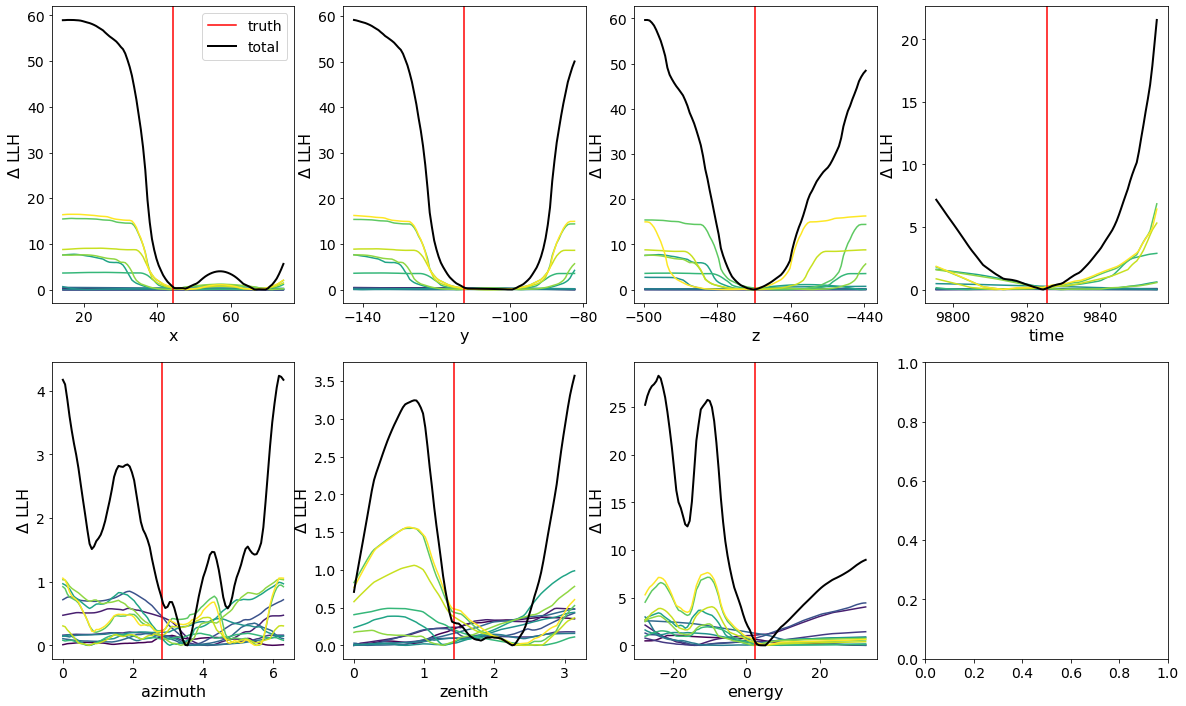

In [590]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12))

for i in range(len(labels)):
        
    axis = ax[i//4, i%4]
    
    plot_llh(345, labels[i], axis)
    
    if i == 0:
        axis.legend()